In [1]:
# pip install joblib

In [2]:
import os
import io
import re
from collections import namedtuple
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random
import argparse
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import gym

In [3]:
Experience = namedtuple("Experience",
                        ["s", "a", "r", "n_s", "d"])

In [4]:
class FNAgent():

    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions
        self.model = None
        self.estimate_probs = False
        self.initialized = False

    def save(self, model_path):
        self.model.save(model_path, overwrite=True, include_optimizer=False)

    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(env.action_space.n))
        agent = cls(epsilon, actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        return agent

    def initialize(self, experiences):
        raise NotImplementedError("You have to implement initialize method.")

    def estimate(self, s):
        raise NotImplementedError("You have to implement estimate method.")

    def update(self, experiences, gamma):
        raise NotImplementedError("You have to implement update method.")

    def policy(self, s):
        #ε-greedy法ね
        if np.random.random() < self.epsilon or not self.initialized:
            return np.random.randint(len(self.actions))
        else:
            estimates = self.estimate(s)
            if self.estimate_probs:
                action = np.random.choice(self.actions,
                                          size=1, p=estimates)[0]
                return action
            else:
                return np.argmax(estimates)

    def play(self, env, episode_count=5, render=True):
        for e in range(episode_count):
            s = env.reset()
            s = s[0]
            done = False
            episode_reward = 0
            while not done:
                if render:
                    env.render()
                a = self.policy(s)
                # n_state, reward, done, info = env.step(a)
                n_state, reward, terminated, truncated, info = env.step(a)
                done = terminated or truncated
                episode_reward += reward
                s = n_state
            else:
                print("Get reward {}.".format(episode_reward))

In [5]:
class Trainer():

    def __init__(self, buffer_size=1024, batch_size=32,
                 gamma=0.9, report_interval=10, log_dir=""):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.report_interval = report_interval
        self.logger = Logger(log_dir, self.trainer_name)
        self.experiences = deque(maxlen=buffer_size)
        self.training = False
        self.training_count = 0
        self.reward_log = []

    @property
    def trainer_name(self):
        class_name = self.__class__.__name__
        snaked = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", class_name)
        snaked = re.sub("([a-z0-9])([A-Z])", r"\1_\2", snaked).lower()
        snaked = snaked.replace("_trainer", "")
        return snaked

    def train_loop(self, env, agent, episode=200, initial_count=-1,
                   render=False, observe_interval=0):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        self.reward_log = []
        frames = []

        for i in range(episode):
            s = env.reset()
            s = s[0]
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            while not done:
                if render:
                    env.render()
                if self.training and observe_interval > 0 and\
                   (self.training_count == 1 or
                    self.training_count % observe_interval == 0):
                    frames.append(s)

                a = agent.policy(s)
                n_state, reward, done, info = env.step(a)
                e = Experience(s, a, reward, n_state, done)
                self.experiences.append(e)
                if not self.training and \
                   len(self.experiences) == self.buffer_size:
                    self.begin_train(i, agent)
                    self.training = True

                self.step(i, step_count, agent, e)

                s = n_state
                step_count += 1
            else:
                self.episode_end(i, step_count, agent)

                if not self.training and \
                   initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True

                if self.training:
                    if len(frames) > 0:
                        self.logger.write_image(self.training_count,
                                                frames)
                        frames = []
                    self.training_count += 1

    def episode_begin(self, episode, agent):
        pass

    def begin_train(self, episode, agent):
        pass

    def step(self, episode, step_count, agent, experience):
        pass

    def episode_end(self, episode, step_count, agent):
        pass

    def is_event(self, count, interval):
        return True if count != 0 and count % interval == 0 else False

    def get_recent(self, count):
        recent = range(len(self.experiences) - count, len(self.experiences))
        return [self.experiences[i] for i in recent]

In [6]:
class Observer():

    def __init__(self, env):
        self._env = env

    @property
    def action_space(self):
        return self._env.action_space

    @property
    def observation_space(self):
        return self._env.observation_space

    # def reset(self):
    #     return self.transform(self._env.reset())

    def reset(self):
        state = self._env.reset()
        if isinstance(state, tuple):  # 新しい形式に対応
            state = state[0]  # 観測値のみを取得
        return self.transform(state)

    def render(self):
        self._env.render(mode="human")

    def step(self, action):
        # n_state, reward, done, info = self._env.step(action)
        n_state, reward, terminated, truncated, info = self._env.step(action)
        done = terminated or truncated
        return self.transform(n_state), reward, done, info

    def transform(self, state):
        raise NotImplementedError("You have to implement transform method.")

In [7]:
class Logger():

    def __init__(self, log_dir="", dir_name=""):
        self.log_dir = log_dir
        if not log_dir:
            # self.log_dir = os.path.join(os.path.dirname(__file__), "logs")
            self.log_dir = os.path.join(os.getcwd(), "logs") #jupyternotebook用
        if not os.path.exists(self.log_dir):
            os.mkdir(self.log_dir)

        if dir_name:
            self.log_dir = os.path.join(self.log_dir, dir_name)
            if not os.path.exists(self.log_dir):
                os.mkdir(self.log_dir)

        self._callback = tf.compat.v1.keras.callbacks.TensorBoard(
                            self.log_dir)

    @property
    def writer(self):
        return self._callback.writer

    def set_model(self, model):
        self._callback.set_model(model)

    def path_of(self, file_name):
        return os.path.join(self.log_dir, file_name)

    def describe(self, name, values, episode=-1, step=-1):
        mean = np.round(np.mean(values), 3)
        std = np.round(np.std(values), 3)
        desc = "{} is {} (+/-{})".format(name, mean, std)
        if episode > 0:
            print("At episode {}, {}".format(episode, desc))
        elif step > 0:
            print("At step {}, {}".format(step, desc))

    def plot(self, name, values, interval=10):
        indices = list(range(0, len(values), interval))
        means = []
        stds = []
        for i in indices:
            _values = values[i:(i + interval)]
            means.append(np.mean(_values))
            stds.append(np.std(_values))
        means = np.array(means)
        stds = np.array(stds)
        plt.figure()
        plt.title("{} History".format(name))
        plt.grid()
        plt.fill_between(indices, means - stds, means + stds,
                         alpha=0.1, color="g")
        plt.plot(indices, means, "o-", color="g",
                 label="{} per {} episode".format(name.lower(), interval))
        plt.legend(loc="best")
        plt.show()

    def write(self, index, name, value):
        summary = tf.compat.v1.Summary()
        summary_value = summary.value.add()
        summary_value.tag = name
        summary_value.simple_value = value
        self.writer.add_summary(summary, index)
        self.writer.flush()

    def write_image(self, index, frames):
        # Deal with a 'frames' as a list of sequential gray scaled image.
        last_frames = [f[:, :, -1] for f in frames]
        if np.min(last_frames[-1]) < 0:
            scale = 127 / np.abs(last_frames[-1]).max()
            offset = 128
        else:
            scale = 255 / np.max(last_frames[-1])
            offset = 0
        channel = 1  # gray scale
        tag = "frames_at_training_{}".format(index)
        values = []

        for f in last_frames:
            height, width = f.shape
            array = np.asarray(f * scale + offset, dtype=np.uint8)
            image = Image.fromarray(array)
            output = io.BytesIO()
            image.save(output, format="PNG")
            image_string = output.getvalue()
            output.close()
            image = tf.compat.v1.Summary.Image(
                        height=height, width=width, colorspace=channel,
                        encoded_image_string=image_string)
            value = tf.compat.v1.Summary.Value(tag=tag, image=image)
            values.append(value)

        summary = tf.compat.v1.Summary(value=values)
        self.writer.add_summary(summary, index)
        self.writer.flush()

In [8]:
class ValueFunctionAgent(FNAgent):

    def save(self, model_path):
        joblib.dump(self.model, model_path)

    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(env.action_space.n))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        return agent

    def initialize(self, experiences):
        #　ここでスケールを
        scaler = StandardScaler()
        estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
        self.model = Pipeline([("scaler", scaler), ("estimator", estimator)])

        #　経験からstateを抜き取る（vstackにexoeriencesから抜き取ったsを）
        states = np.vstack([e.s for e in experiences])
        #んで学習
        self.model.named_steps["scaler"].fit(states)

        # Avoid the predict before fit.
        self.update([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    def estimate(self, s):
        # estimated = self.model.predict(s)[0]
        # return estimated

        s = np.array(s).reshape(1, -1)  # 2次元配列に変換
        estimated = self.model.predict(s)[0]
        return estimated

    def _predict(self, states):
        if self.initialized:
            predicteds = self.model.predict(states)

        #モデルが初期化されていない，つまりまだモデルの準備ができていないとしても何かしらの予測値としてランダムに
        #出力することができる
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
            print("non predictation")
        return predicteds

    def update(self, experiences, gamma):
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])

        estimateds = self._predict(states)
        future = self._predict(n_states)

        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                #ここで実装するのはoff-policyになっているので価値が最大になる行動をとることを前提とする
                reward += gamma * np.max(future[i])

            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = self.model.named_steps["scaler"].transform(states)
        self.model.named_steps["estimator"].partial_fit(states, estimateds)

In [9]:
class CartPoleObserver(Observer):

    def transform(self, state):
        return np.array(state).reshape((1, -1))

In [10]:
class ValueFunctionTrainer(Trainer):

    def train(self, env, episode_count=220, epsilon=0.1, initial_count=-1,
              render=False):
        actions = list(range(env.action_space.n))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count, render)
        return agent

    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            agent.update(batch, self.gamma)

    def episode_end(self, episode, step_count, agent):
        rewards = [e.r for e in self.get_recent(step_count)]
        self.reward_log.append(sum(rewards))

        if self.is_event(episode, self.report_interval):
            recent_rewards = self.reward_log[-self.report_interval:]
            self.logger.describe("reward", recent_rewards, episode=episode)

In [11]:
def main(play):
    env = CartPoleObserver(gym.make("CartPole-v0"))
    trainer = ValueFunctionTrainer()
    path = trainer.logger.path_of("value_function_agent.pkl")

    if play:
        agent = ValueFunctionAgent.load(env, path)
        agent.play(env)
    else:
        trained = trainer.train(env)
        trainer.logger.plot("Rewards", trainer.reward_log,
                            trainer.report_interval)
        trained.save(path)

        

In [12]:
def main(play):
    env = CartPoleObserver(gym.make("CartPole-v0"))
    trainer = ValueFunctionTrainer()
    path = trainer.logger.path_of("value_function_agent.pkl")

    if play:
        print("Playing with trained model")
        agent = ValueFunctionAgent.load(env, path)
        agent.play(env)
    else:
        print("Training mode")
        trained = trainer.train(env)
        trainer.logger.plot("Rewards", trainer.reward_log,
                            trainer.report_interval)
        trained.save(path)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Training mode
At episode 10, reward is 22.1 (+/-4.763)
At episode 20, reward is 20.5 (+/-11.952)
At episode 30, reward is 22.5 (+/-12.176)
At episode 40, reward is 28.6 (+/-12.603)
non predictation
non predictation
Done initialization. From now, begin training!
At episode 50, reward is 15.7 (+/-11.917)
At episode 60, reward is 10.2 (+/-1.249)
At episode 70, reward is 10.7 (+/-1.487)
At episode 80, reward is 13.4 (+/-6.621)
At episode 90, reward is 16.6 (+/-7.2)
At episode 100, reward is 19.7 (+/-11.507)
At episode 110, reward is 51.3 (+/-26.959)
At episode 120, reward is 47.4 (+/-24.989)
At episode 130, reward is 44.3 (+/-12.0)
At episode 140, reward is 67.9 (+/-14.053)
At episode 150, reward is 91.4 (+/-10.365)
At episode 160, reward is 96.4 (+/-13.306)
At episode 170, reward is 86.8 (+/-13.948)
At episode 180, reward is 91.4 (+/-9.562)
At episode 190, reward is 101.1 (+/-26.678)
At episode 200, reward is 100.1 (+/-26.527)
At episode 210, reward is 113.5 (+/-16.609)


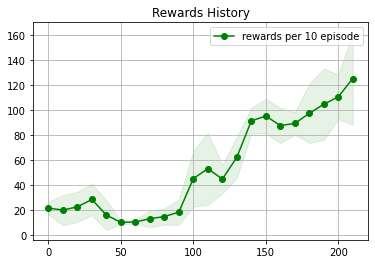

In [13]:
main(play=False)